In [2]:
#imports 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#normalization
from sklearn.preprocessing import OneHotEncoder, StandardScaler

#splitting and feature selection
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold

#model
from sklearn.neighbors import KNeighborsClassifier

#evaluation
from sklearn import metrics

In [26]:
def soilrm(df):
    df2 = df[df["Classification"] != "soil"]
    return df2

In [16]:
#box location for Alex
data_dir = "/Users/alexlukasiewicz/Box Sync/Spring 2023/Sci Machine Learning/Bio Team SDS384/Datasets"

#data import
cog = pd.read_csv(data_dir + "/Levy_2017_datasets/cogs_pfams_tigrfam_ko/cog_ratios.csv")

pfam = pd.read_csv(data_dir + "/Levy_2017_datasets/cogs_pfams_tigrfam_ko/pfam_ratios.csv")

dbcan = pd.read_csv(data_dir + "/dbcan4_outputs/dbcan_result.3772genomes.matrix.divided_by_gene_counts.tsv", sep="\t")

In [29]:
dbcan = pd.read_csv(data_dir + "/dbcan4_outputs/dbcan_result.3772genomes.matrix.divided_by_gene_counts.tsv", sep="\t")
#remove soil from all three datasets 

cog = soilrm(cog)

pfam = soilrm(pfam)

dbcan = soilrm(dbcan)

In [30]:
#Scale datasets and generate presence/ absence pfam dataframe (0,1)
dbcan = dbcan.rename(columns = {"taxonID" : "2016_taxon_oid"})

#add hgt % to dbcan dataset
dbcan = pd.merge(dbcan, cog[['2016_taxon_oid', 'Horizontally_Transferred_%']], 
                             on='2016_taxon_oid', 
                             how='left')

,AA1,AA10,AA12,AA3,AA4,AA5,AA6,AA7,CBM11,CBM12,...,PL4,PL40,PL41,PL42,PL5,PL6,PL7,PL8,PL9,Horizontally_Transferred_%
0,0.066808,-0.378513,-0.423784,-0.389091,1.002863,-0.170719,2.537982,-0.644416,-0.115373,-0.150815,...,-0.171868,-0.076578,-0.069918,-0.186466,-0.32207,-0.174265,-0.269088,-0.196259,-0.284263,-0.331415
1,0.136692,-0.378513,2.474260,-0.348927,1.096538,-0.170719,1.528209,-0.644416,-0.115373,-0.150815,...,-0.171868,-0.076578,-0.069918,-0.186466,-0.32207,-0.174265,-0.269088,-0.196259,-0.284263,-0.313281
2,0.121340,-0.378513,2.441586,-0.357750,1.075959,-0.170719,2.681372,-0.644416,-0.115373,-0.150815,...,-0.171868,-0.076578,-0.069918,-0.186466,-0.32207,-0.174265,-0.269088,-0.196259,-0.284263,-0.331415
3,1.317699,-0.378513,-0.423784,-0.400855,0.975425,-0.170719,2.484157,-0.644416,-0.115373,-0.150815,...,-0.171868,-0.076578,-0.069918,-0.186466,-0.32207,-0.174265,-0.269088,-0.196259,-0.284263,-0.218343
4,0.123815,-0.378513,2.446855,-0.356327,1.079278,-0.170719,2.687882,-0.644416,-0.115373,-0.150815,...,-0.171868,-0.076578,-0.069918,-0.186466,-0.32207,-0.174265,-0.269088,-0.196259,-0.284263,-0.294080


In [43]:
dbcan.describe()

,2016_taxon_oid,AA1,AA10,AA12,AA3,AA4,AA5,AA6,AA7,CBM11,...,PL4,PL40,PL41,PL42,PL5,PL6,PL7,PL8,PL9,Horizontally_Transferred_%
count,3.261000e+03,3261.000000,3261.000000,3261.000000,3261.000000,3261.000000,3261.000000,3261.000000,3261.000000,3261.000000,...,3261.000000,3261.000000,3261.000000,3261.000000,3261.000000,3261.000000,3261.000000,3261.000000,3261.000000,3261.000000
mean,2.400029e+09,0.000239,0.000056,0.000039,0.000383,0.000106,0.000011,0.000191,0.000178,0.000003,...,0.000007,0.000004,0.000001,0.000010,0.000020,0.000016,0.000042,0.000017,0.000022,3.206884
std,5.488273e+08,0.000195,0.000148,0.000092,0.000339,0.000145,0.000064,0.000222,0.000276,0.000022,...,0.000041,0.000047,0.000016,0.000054,0.000062,0.000090,0.000157,0.000089,0.000076,9.376052
min,6.370000e+08,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.524023e+09,0.000126,0.000000,0.000000,0.000148,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.050000
50%,2.565957e+09,0.000241,0.000000,0.000000,0.000312,0.000000,0.000000,0.000159,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.600000
75%,2.585428e+09,0.000323,0.000000,0.000000,0.000536,0.000238,0.000000,0.000276,0.000267,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.660000
max,2.645728e+09,0.001379,0.002212,0.000598,0.002302,0.001967,0.000737,0.000917,0.001654,0.000395,...,0.000590,0.001142,0.000325,0.001201,0.000670,0.001137,0.003640,0.001492,0.000678,97.940000


In [37]:
#x and y variables
variables = dbcan.columns[:4]
classif = dbcan['Classification']

scaler = StandardScaler()
dbcan_normalized = pd.DataFrame(scaler.fit_transform(dbcan.iloc[:,4:]), columns = dbcan.iloc[:,4:].columns)
dbcan_normalized.head()

,AA1,AA10,AA12,AA3,AA4,AA5,AA6,AA7,CBM11,CBM12,...,PL4,PL40,PL41,PL42,PL5,PL6,PL7,PL8,PL9,Horizontally_Transferred_%
0,0.066808,-0.378513,-0.423784,-0.389091,1.002863,-0.170719,2.537982,-0.644416,-0.115373,-0.150815,...,-0.171868,-0.076578,-0.069918,-0.186466,-0.32207,-0.174265,-0.269088,-0.196259,-0.284263,-0.331415
1,0.136692,-0.378513,2.474260,-0.348927,1.096538,-0.170719,1.528209,-0.644416,-0.115373,-0.150815,...,-0.171868,-0.076578,-0.069918,-0.186466,-0.32207,-0.174265,-0.269088,-0.196259,-0.284263,-0.313281
2,0.121340,-0.378513,2.441586,-0.357750,1.075959,-0.170719,2.681372,-0.644416,-0.115373,-0.150815,...,-0.171868,-0.076578,-0.069918,-0.186466,-0.32207,-0.174265,-0.269088,-0.196259,-0.284263,-0.331415
3,1.317699,-0.378513,-0.423784,-0.400855,0.975425,-0.170719,2.484157,-0.644416,-0.115373,-0.150815,...,-0.171868,-0.076578,-0.069918,-0.186466,-0.32207,-0.174265,-0.269088,-0.196259,-0.284263,-0.218343
4,0.123815,-0.378513,2.446855,-0.356327,1.079278,-0.170719,2.687882,-0.644416,-0.115373,-0.150815,...,-0.171868,-0.076578,-0.069918,-0.186466,-0.32207,-0.174265,-0.269088,-0.196259,-0.284263,-0.294080


In [34]:
#checking for balance of PA:NPA counts
dbcan['Classification'].describe()

count     3261
unique       2
top        NPA
freq      2117
Name: Classification, dtype: object

The data appears to be roughly 65% NPA, and 35% PA. It may be a good idea to stratify the train_test split function here 

In [45]:
#split the dataset, but stratify by classification
X_train, X_test, y_train, y_test = train_test_split(dbcan_normalized, classif, test_size=0.33, random_state=42, stratify=classif)

In [74]:
#feature selection using training dataset
from sklearn.feature_selection import SelectKBest

#evaluating accuracy
from sklearn import metrics

# select features 
selector = SelectKBest(k=50)
X_train_selected = selector.fit_transform(X_train,y_train)

neighbors = range(1,11)
accuracy = []

for n in neighbors:
    #fit using KNeighbors
    KNC = KNeighborsClassifier(n_neighbors = n)
    KNC.fit(X_train_selected, y_train)

    # select the same features on the test set, predict, and get the test accuracy:
    X_test_selected = selector.transform(X_test)
    y_pred = KNC.predict(X_test_selected)
    
    #log accuracy
    accuracy.append(metrics.accuracy_score(y_test, y_pred))


/usr/local/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [ 12  21  56  84 139 151 281 338] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


/var/folders/yf/pl2fqbcj153fvwq1yflkkhcm0000gn/T/ipykernel_46421/3294862785.py:2: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo-" (-> color='b'). The keyword argument will take precedence.
  plt.plot(neighbors, accuracy, 'bo-', color='steelblue')


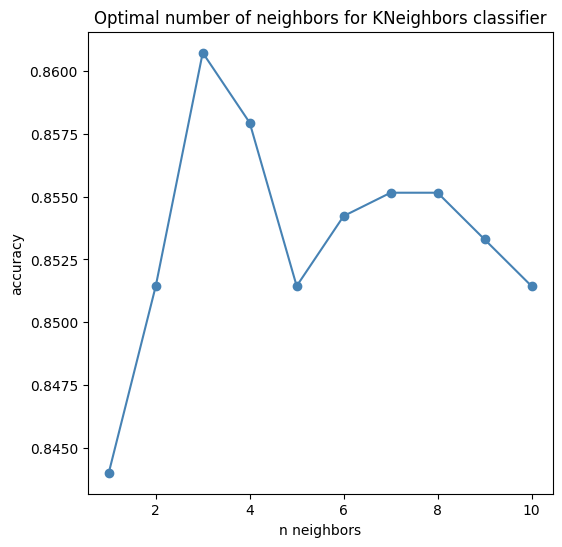

In [76]:
plt.figure(figsize=(6,6))
plt.plot(neighbors, accuracy, 'bo-', color='steelblue')
plt.xlabel('n neighbors')
plt.ylabel('accuracy')
plt.title('Optimal number of neighbors for KNeighbors classifier')
plt.show()


In [57]:
#evaluating accuracy
from sklearn import metrics
# Model Accuracy, how often is the classifier correct?
print("Accuracy KNeighbors:",metrics.accuracy_score(y_test, y_pred))

Accuracy KNeighbors: 0.8440111420612814


In [51]:
#feature selection using boruta scripts https://towardsdatascience.com/simple-example-using-boruta-feature-selection-in-python-8b96925d5d7a#:~:text=During%20the%20fit%2C%20Boruta%20will,noise%2C%20and%20therefore%20worth%20keeping.

from sklearn.ensemble import RandomForestClassifier

# define random forest classifier
forest = RandomForestClassifier(n_jobs=-1, class_weight='balanced', max_depth=5)
forest.fit(X_train, y_train)

from boruta import BorutaPy

# define Boruta feature selection method
feat_selector = BorutaPy(forest, n_estimators='auto', verbose=2, random_state=1)

# find all relevant features
feat_selector.fit(X_train, y_train)

# check selected features
feat_selector.support_

# check ranking of features
feat_selector.ranking_

# call transform() on X to filter it down to selected features
X_filtered = feat_selector.transform(X_train)

# zip my names, ranks, and decisions in a single iterable
feature_ranks = list(zip(data.feature_names, 
                         feat_selector.ranking_, 
                         feat_selector.support_))

# iterate through and print out the results
for feat in feature_ranks:
    print('Feature: {:<25} Rank: {},  Keep: {}'.format(feat[0], feat[1], feat[2]))



InvalidIndexError: (slice(None, None, None), array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181,
       182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194,
       195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207,
       208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220,
       221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233,
       234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246,
       247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259,
       260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272,
       273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284, 285,
       286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298,
       299, 300, 301, 302, 303, 304, 305, 306, 307, 308, 309, 310, 311,
       312, 313, 314, 315, 316, 317, 318, 319, 320, 321, 322, 323, 324,
       325, 326, 327, 328, 329, 330, 331, 332, 333, 334, 335, 336, 337,
       338, 339, 340, 341, 342, 343, 344, 345, 346, 347, 348]))

In [64]:
X_train_selected

array([[ 1.04862203e+00, -4.23783691e-01,  8.28541213e-01, ...,
        -2.40246878e-01, -1.71868079e-01,  3.22638797e+00],
       [-1.22502280e+00, -4.23783691e-01, -2.08414075e-01, ...,
        -2.40246878e-01, -1.71868079e-01, -3.22069657e-01],
       [ 7.58085853e-03, -4.23783691e-01,  2.85277345e-01, ...,
        -2.40246878e-01, -1.71868079e-01, -3.22069657e-01],
       ...,
       [ 5.21841740e-03, -4.23783691e-01, -4.24487710e-01, ...,
        -2.40246878e-01,  5.71256698e+00, -3.22069657e-01],
       [-1.22502280e+00, -4.23783691e-01, -1.13153726e+00, ...,
        -2.40246878e-01, -1.71868079e-01, -3.22069657e-01],
       [ 4.45991467e-01, -4.23783691e-01,  3.09021553e-01, ...,
        -2.40246878e-01, -1.71868079e-01,  2.28586771e+00]])